# Gradient vector flow

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
image = io.imread('../data/nuclei.tif')[:200,:200]


In [278]:
from skimage.color import hsv2rgb
from math import pi
def flow2rgb(v):    
    r = np.sqrt(np.sum(np.square(v), axis=0))
    r = 255*r / r.max()
    a = np.arctan2(v[1], v[0])
    a = (2*pi - a) / (2*pi) 
    return hsv2rgb(np.stack([a,np.ones_like(r),r],axis=2)).astype(np.uint8)

def show_flow(v):
    plt.imshow(flow2rgb(v))
    x,y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    plt.quiver(x[::5,::5],y[::5,::5],v[1,::5,::5],-v[0,::5,::5])
    plt.axis('off')


In [93]:
v.shape

(2, 100, 100)

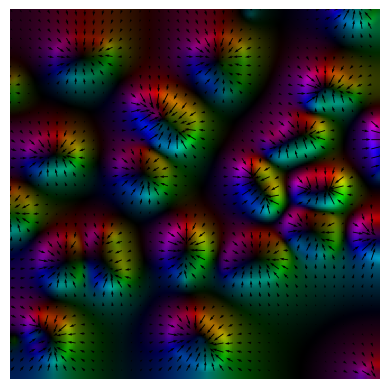

In [279]:
from scipy import ndimage

def gradient_vector_flow(image):
    f = np.stack(np.gradient(ndimage.gaussian_filter(image,2)))
    q = np.sum(np.square(f), axis=0)
    q[q<q.mean()] = 0
    q[q>0] = 0.5
    v = f
    for _ in range(1000):
        dv = np.stack([ndimage.laplace(x) for x in v]) + q * (f - v)
        v = v +  dv / np.abs(dv).max()
    return v

v = gradient_vector_flow(image)
#v[0] = -v[0]
show_flow(v)


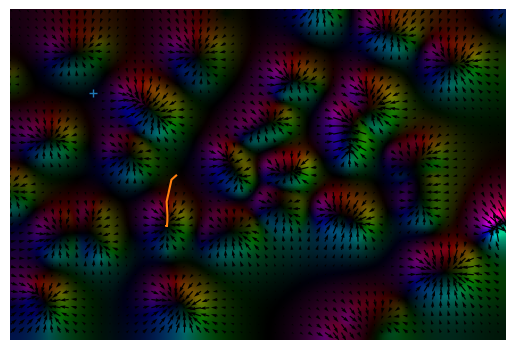

In [226]:
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
X, Y = np.meshgrid(x,y)
fx = RegularGridInterpolator((y, x), v[1], bounds_error=False, fill_value=None)
fy = RegularGridInterpolator((y, x), v[0], bounds_error=False, fill_value=None)
sol=solve_ivp(lambda t, p: np.squeeze([fy(p),fx(p)]), [0,200], [100,100])
show_flow(v)
plt.plot(50,50,'+')
plt.plot(sol.y[1], sol.y[0])

In [250]:

sol = solve_ivp(lambda t, p: np.squeeze([fy(p),fx(p)]), [0,200], [100,100])

In [281]:
def solve_streamline(v,x0):
    x = x0.astype(int)
    for _ in range(100):
        dx = np.round(np.squeeze([v[0,x[0],x[1]], v[1,x[0],x[1]]])).astype(int)
        x = x + dx
        x = np.maximum(0,np.minimum(np.array(v[0].shape)-1, x))
        if (np.linalg.norm(dx) == 0):
            break
    return x

def trace_flow(v):
    x = np.arange(v.shape[2])
    y = np.arange(v.shape[1])
    X, Y = np.meshgrid(x,y)    
    label = np.zeros(v.shape, dtype=int)
    for xs,ys in zip(X.ravel(),Y.ravel()):    
        label[:,ys,xs] = solve_streamline(v, np.squeeze([ys,xs]))
    return label

    
label = trace_flow(v)

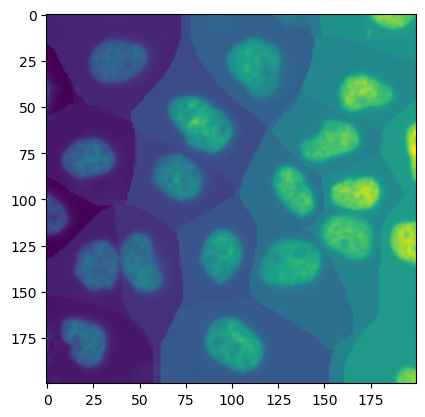

In [283]:
plt.imshow(label[1]+image)